# Time Series Forecasting 
## SARIMA Model - Sales Value of Manufactured Nondurable Consumer Goods (Euro Area)

Sales are measured as turnover, i.e. the ex-works value of goods that are sold (invoiced) by the observation unit during the reference period, whether they are taken from stocks or from the production of the reference period.
Data refer to the 17 Euro area member states since 1995 [[OECD]](https://stats.oecd.org/viewhtml.aspxdatasetcode=MEI&lang=en).
ARIMA models are applied in some cases where data show evidence of non-stationarity in the sense of mean, where an initial differencing step (corresponding to the "integrated" part of the model) can be applied one or more times to eliminate the non-stationarity of the mean function (i.e., the trend) [[Wikipedia]](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average). Sometimes a seasonal effect is suspected in the model; in that case, it is generally considered better to use a SARIMA (seasonal ARIMA) model than to increase the order of the AR or MA parts of the model. 
When the seasonality shows in a time series, the seasonal-differencing could be applied to eliminate the seasonal component. 



---

Data source: Organization for Economic Co-operation and Development, Sales: Manufacturing: Consumer goods non durable: Value for the Euro Area [EA19SLMNCN02IXOBM], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/EA19SLMNCN02IXOBM, March 8, 2022. <br>

Frequency: Monthly <br>
Date range: 2000/01/01 - 2021/11/1 <br>
Units: Index 2015=100, Not Seasonally Adjusted <br>
Updated: Feb 15, 2022

🏷️: <em> stationarit, SARIMA, residual diagnostic, forecasting </em>

#### Packages, modules, options and functions

In [1]:
# Packages & modules
from arch.unitroot import PhillipsPerron
from numpy import diff, random, transpose
from pandas import Series, read_csv, to_datetime
from pmdarima.arima import auto_arima
from scipy.special import inv_boxcox
from scipy.stats import anderson, boxcox, jarque_bera, kurtosis, shapiro, skew
from seaborn import color_palette, histplot, kdeplot, lineplot
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch, het_white
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss   
from statsmodels.tools.tools import add_constant


#Plot parameters
from matplotlib import pyplot, pylab
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')
params = {'figure.titlesize':'medium', 'axes.titlesize':'medium',
          'legend.fontsize': 'x-small', 'legend.title_fontsize': 'x-small',
          'axes.labelsize': 'x-small', 
          'xtick.labelsize':'xx-small', 'ytick.labelsize':'xx-small',
          'figure.dpi':150}
pylab.rcParams.update(params)

### 1. Data preparation

In [2]:
data = read_csv('data.csv', parse_dates=['DATE'], index_col='DATE')
data.columns = ['value']
data.index.names = [None]

print(data.head(5))

            value
2000-01-01   68.2
2000-02-01   71.3
2000-03-01   78.8
2000-04-01   74.0
2000-05-01   74.4


In [3]:
train = data.head(int(len(data)*0.9)).copy()
test = data.tail(int(len(data)*0.1)).copy()

### 2. Data visualization

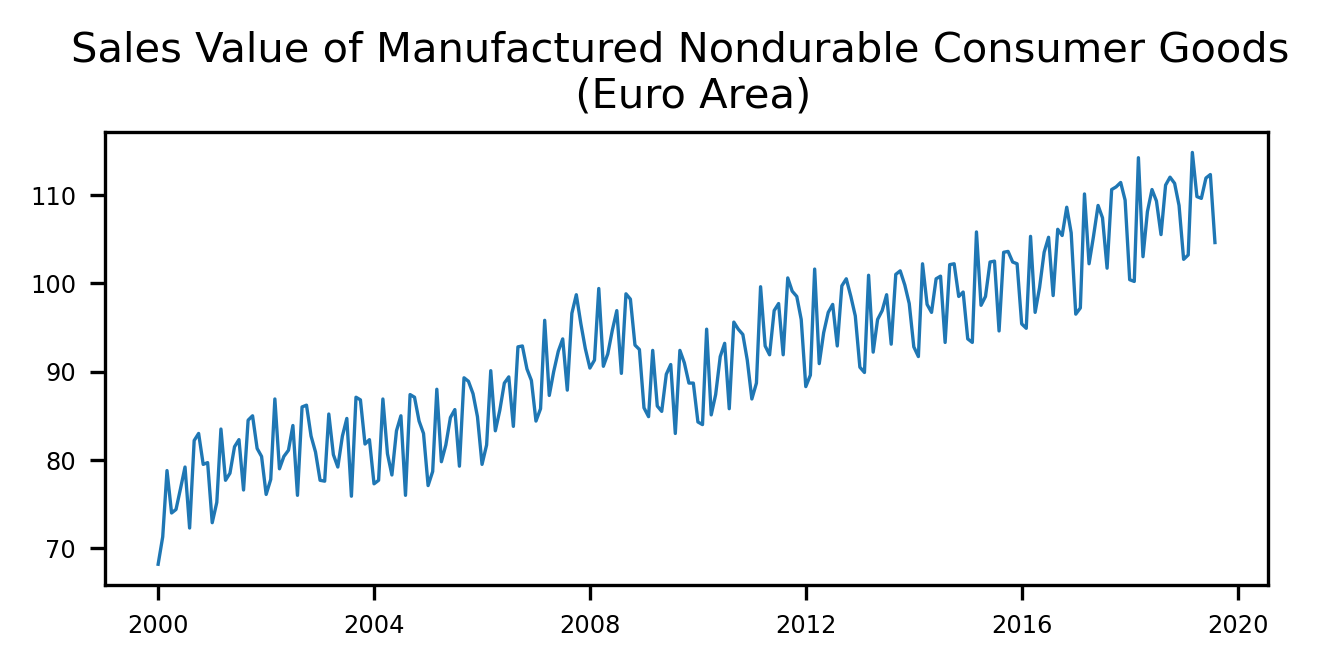

In [4]:
fig, ax = pyplot.subplots(figsize=(5,2))

lineplot(data=train.value, linewidth=.8)
ax.set_title('Sales Value of Manufactured Nondurable Consumer Goods \n (Euro Area)')
ax.set_ylabel(None)

pyplot.show()

In [5]:
stl = STL(train.value).fit()

train['trend'] = stl.trend
train['seasonal'] = stl.seasonal
train['resid'] = stl.resid

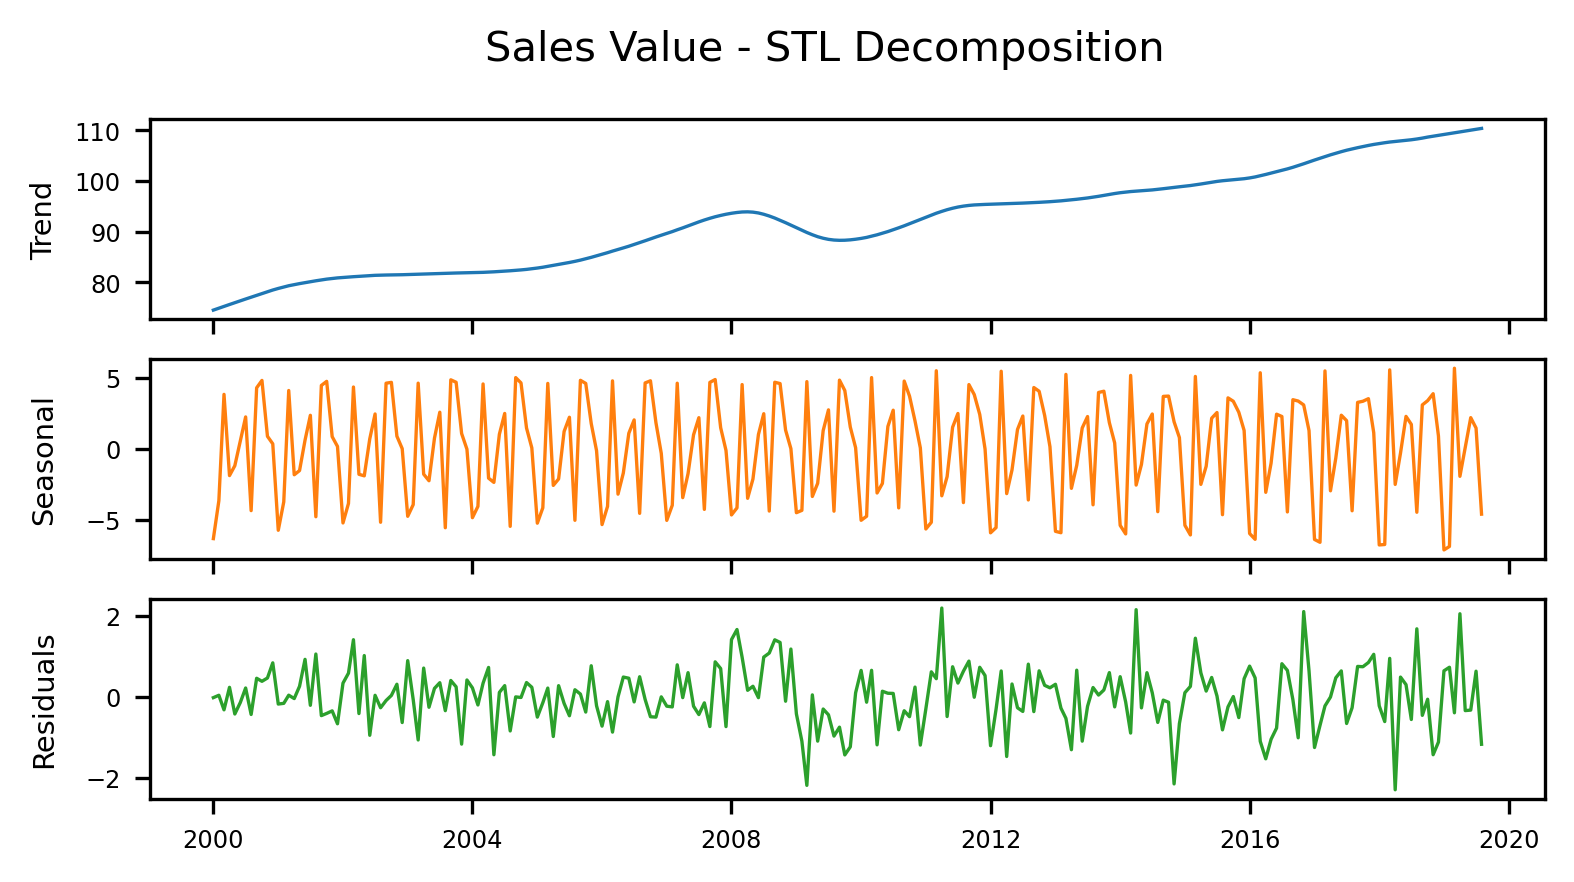

In [6]:
fig, axs = pyplot.subplots(3, 1, figsize=(6,3), sharex=True)

color = color_palette('tab10')
labels = ['Trend', 'Seasonal', 'Residuals']
for i, ax in enumerate(axs.flatten()):
        lineplot(ax=ax, data=train.iloc[:,i+1], linewidth=.8, color=color[i])
        ax.set_ylabel(labels[i])

fig.suptitle('Sales Value - STL Decomposition')
fig.align_labels()

pyplot.show()

Time series does not look stationary because it exhibits an increasing trend and a seasonal pattern within each year.

### 3. Data pre-processing

In [7]:
print('ADF statistic: %.4f' % adfuller(train.value)[0])
print('p-value: %.4f' % adfuller(train.value)[1])
print('KPSS statistic: %.4f' % kpss(train.value, regression='ct')[0])
print('p-value: %.4f' % kpss(train.value)[1])

ADF statistic: -0.3922
p-value: 0.9114
KPSS statistic: 0.1390
p-value: 0.0100


p-value of ADF test is larger than 0.05 so the null hypothesis of unit root cannot be rejected. <br>
p-value of KPSS test is less than 0.05 so the null hypothesis of trend-stationarity is rejected. <br>
The series is neither stationary nor trend-stationary.

Apply log transformation. <br> 
Remove seasonality by seasonally adjust data with differencing. <br>
Remove trend by taking the 1st order difference of the series.

In [8]:
train['boxcox'] = boxcox(train.value, 0)
train['seas_diff'] = train.boxcox.diff(12).diff(1)
train.dropna(inplace=True)

In [9]:
print('ADF statistic: %.4f' % adfuller(train.seas_diff)[0])
print('p-value: %.4f' % adfuller(train.seas_diff)[1])
print('PP statistic: %.4f' % PhillipsPerron(train.seas_diff).stat)
print('p-value: %.4f' % PhillipsPerron(train.seas_diff).pvalue)

ADF statistic: -4.6829
p-value: 0.0001
PP statistic: -26.1467
p-value: 0.0000


p-value of ADF test is less than 0.05 so the null hypothesis of unit root is rejected. <br>
p-value of PP test is less than 0.05 so the null hypothesis of unit root is rejected. <br>
Both tests conclude that the series is stationary.

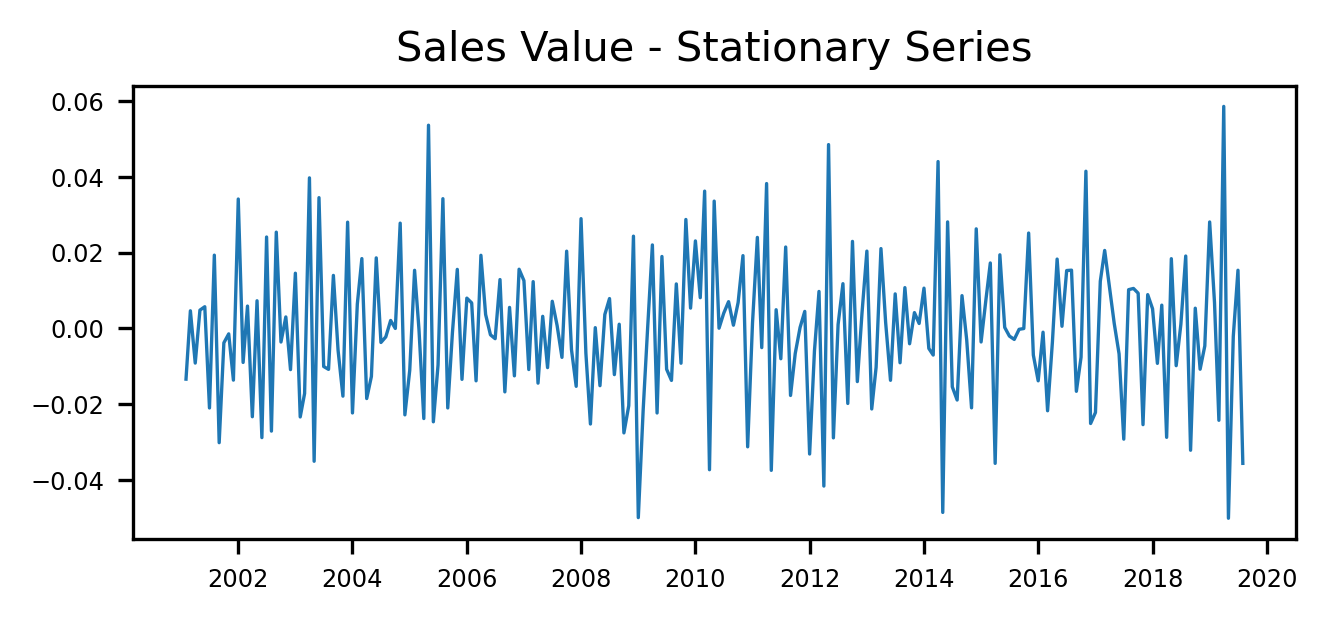

In [10]:
fig, ax = pyplot.subplots(figsize=(5,2))

lineplot(data=train.seas_diff, linewidth=.8)
ax.set_title('Sales Value - Stationary Series')
ax.set_ylabel(None)

pyplot.show()

### 4. Model fitting

In [11]:
sarima = auto_arima(train.boxcox, d=1, D=1, seasonal=True, m=12, 
                   max_order=None, max_q=5, max_p=5, max_Q=5, max_P=5,
                   stepwise=True, information_criterion='bic')
print(sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  223
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 596.900
Date:                            Thu, 24 Mar 2022   AIC                          -1183.801
Time:                                    21:09:19   BIC                          -1167.065
Sample:                                         0   HQIC                         -1177.035
                                            - 223                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9422      0.165     -5.705      0.000      -1.266      -0.619
ar.L2         -0.4935      0.080   

p-values of all terms in the model are less than 0.05 so the coefficients are statistically significant.

In [12]:
fitted = Series(inv_boxcox(sarima.predict_in_sample(), 0))[13:]
fitted.index = train.index[13:]

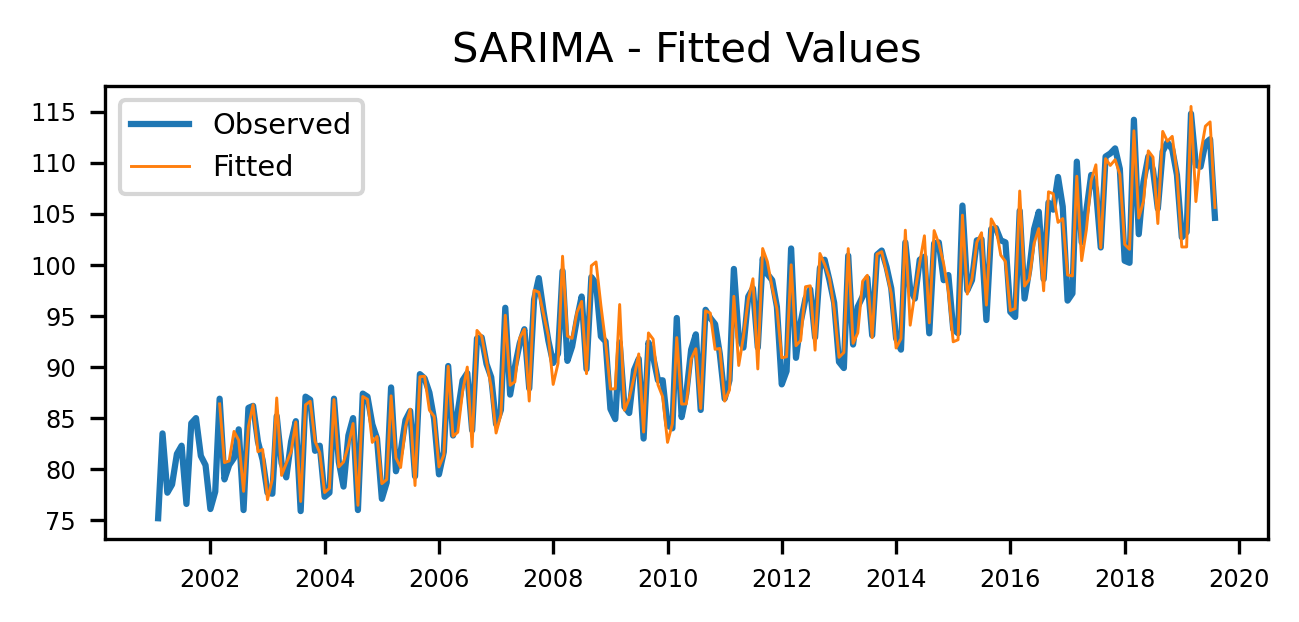

In [13]:
fig, ax = pyplot.subplots(figsize=(5,2))

lineplot(data=train.value,  label='Observed')
lineplot(data=fitted, linewidth=.7, label='Fitted')

ax.set_title('SARIMA - Fitted Values')
ax.legend(loc='upper left')
ax.set_ylabel(None)
ax.set_xlabel(None)

pyplot.show()

### 5. Model diagnostics

In [14]:
sarima_resid = Series(sarima.resid()).iloc[13:]

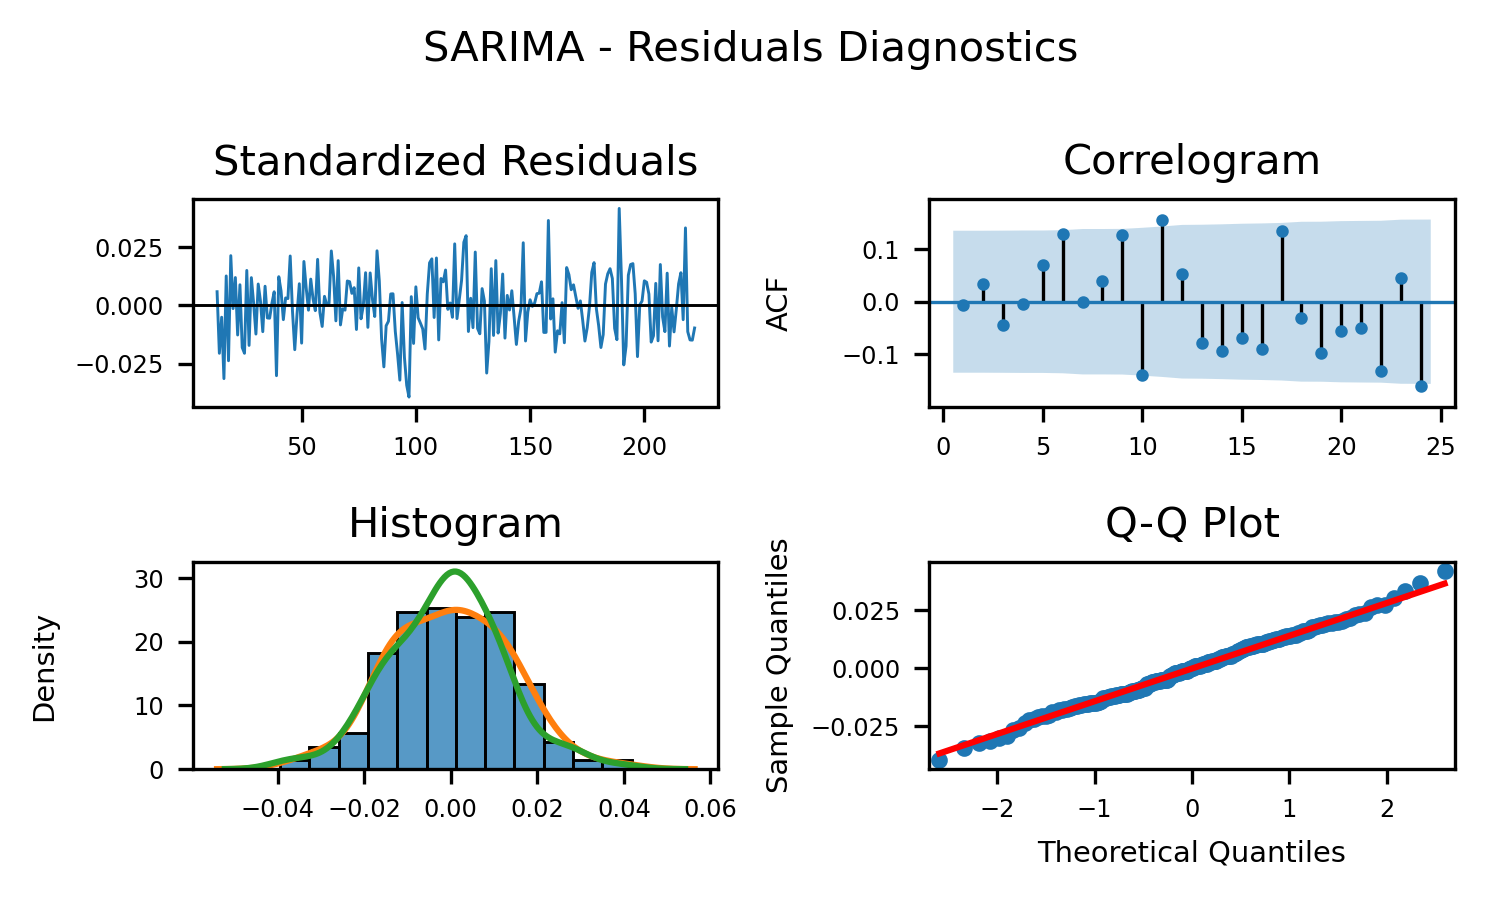

In [15]:
fig, axs = pyplot.subplot_mosaic([['line', 'acf'],
                                   ['hist', 'qq']],
                                  figsize=(5, 3))

fig.suptitle('SARIMA - Residuals Diagnostics')

lineplot(ax=axs['line'], data=sarima_resid, linewidth=.7)
axs['line'].axhline(y=0, linewidth=.7, color='black')
axs['line'].set_title('Standardized Residuals')

plot_acf(ax=axs['acf'], x=sarima_resid, 
         zero=False, auto_ylims=True, title=None,
         markersize=2, linewidth=.8, vlines_kwargs={'color':'black', 'linewidth':.8})
axs['acf'].set_title('Correlogram')
axs['acf'].set_ylabel('ACF')

rng = random.default_rng(1)
norm = rng.normal(sarima_resid.mean(), sarima_resid.std(), len(sarima_resid))
histplot(ax=axs['hist'], data=sarima_resid, linewidth=.7, stat='density')
kdeplot(ax=axs['hist'], data=sarima_resid, color='tab:orange')
kdeplot(ax=axs['hist'], data=norm, color='tab:green')
axs['hist'].set_ylabel('Density')
axs['hist'].set_title('Histogram')

qqplot(ax=axs['qq'], data=sarima_resid, line='s', markersize=3)
axs['qq'].set_title('Q-Q Plot')

fig.align_labels()
pyplot.tight_layout()

pyplot.show()

In [16]:
print(acorr_ljungbox(sarima_resid, boxpierce=True))

      lb_stat  lb_pvalue    bp_stat  bp_pvalue
1    0.010787   0.917280   0.010634   0.917865
2    0.260327   0.877952   0.255466   0.880088
3    0.668720   0.880535   0.654227   0.883914
4    0.672190   0.954714   0.657599   0.956453
5    1.727006   0.885480   1.677586   0.891711
6    5.308923   0.504845   5.124337   0.527968
7    5.308923   0.622320   5.124337   0.644793
8    5.657043   0.685586   5.456035   0.707906
9    9.211552   0.417980   8.826113   0.453478
10  13.494169   0.197339  12.866317   0.231243


ACF plot shows little to none autocorrelation. <br>
p-values of Ljung-Box test for autocorrelation are larger than 0.05 so the null hypothesis of independent distribution cannot be rejected. <br>
p-values of Box-Pierce test for autocorrelation are larger than 0.05 so the null hypothesis of independent distribution cannot be rejected. <br>
All checks conclude that the residuals do not exhibit serial correlation.

In [17]:
print('Residual mean: %.4f' % sarima_resid.mean())

Residual mean: -0.0002


The mean of the residuals is very close to zero so the forecasts are unbiased.

In [18]:
print('Skewness: %.4f' % skew(sarima_resid, bias=False))
print('Kurtosis (Pearson): %.4f' % kurtosis(sarima_resid, bias=False, fisher=False))

print('Shapiro-Wilk statistic: %.4f' % shapiro(sarima_resid).statistic)
print('p-value: %.4f' % shapiro(sarima_resid).pvalue)
print('Anderson–Darling statistic: %.4f' % anderson(sarima_resid, 'norm').statistic)
print('critical value (α=0.05): %.4f' % anderson(sarima_resid, 'norm').critical_values[2])

Skewness: 0.0292
Kurtosis (Pearson): 2.9509
Shapiro-Wilk statistic: 0.9969
p-value: 0.9562
Anderson–Darling statistic: 0.2469
critical value (α=0.05): 0.7730


Histogram and Q-Q plot suggests that the residuals may be normally distributed. <br>
Skewness is close to zero and Kurtosis is close to 3, as it would be expected for a normal distribution. <br>
p-value of Shapiro-Wilk test for normality is larger than 0.05 so the null hypothesis of normal distribution cannot be rejected. <br>
Anderson-Darling test statistic is less than critical value at 5% significance level so the null hypothesis of normal distribution cannot be rejected. <br>
All checks conclude that the residuals are normally distributed.

In [19]:
print('Engle ARCH LM statistic: %.4f' % het_arch(sarima_resid, ddof=5)[0])
print('p-value: %.4f' % het_arch(sarima_resid, ddof=5)[1])
print('White LM statistic: %.4f' % het_white(sarima_resid, add_constant(sarima_resid.index))[0])
print('p-value: %.4f' % het_white(sarima_resid, add_constant(sarima_resid.index))[1])

Engle ARCH LM statistic: 4.5481
p-value: 0.9193
White LM statistic: 0.0739
p-value: 0.9637


p-value of Engle ARCH test for heteroskedasticity is larger than 0.05 so the null hypothesis of homoskedasticity cannot be rejected. <br>
p-value of White test for heteroskedasticity is larger than 0.05 so the null hypothesis of homoskedasticity cannot be rejected. <br>
Both checks conclude that the residuals are homoskedastic.

### 6. Forecasting

In [20]:
test = data.tail(int(len(data)*0.1)).copy()

fcast, confint = Series(sarima.predict(n_periods=len(test), return_conf_int=True))

test['forecast'] = inv_boxcox(fcast, 0)
test['lower'] = inv_boxcox(confint[:,0], 0)
test['upper'] = inv_boxcox(confint[:,1], 0)

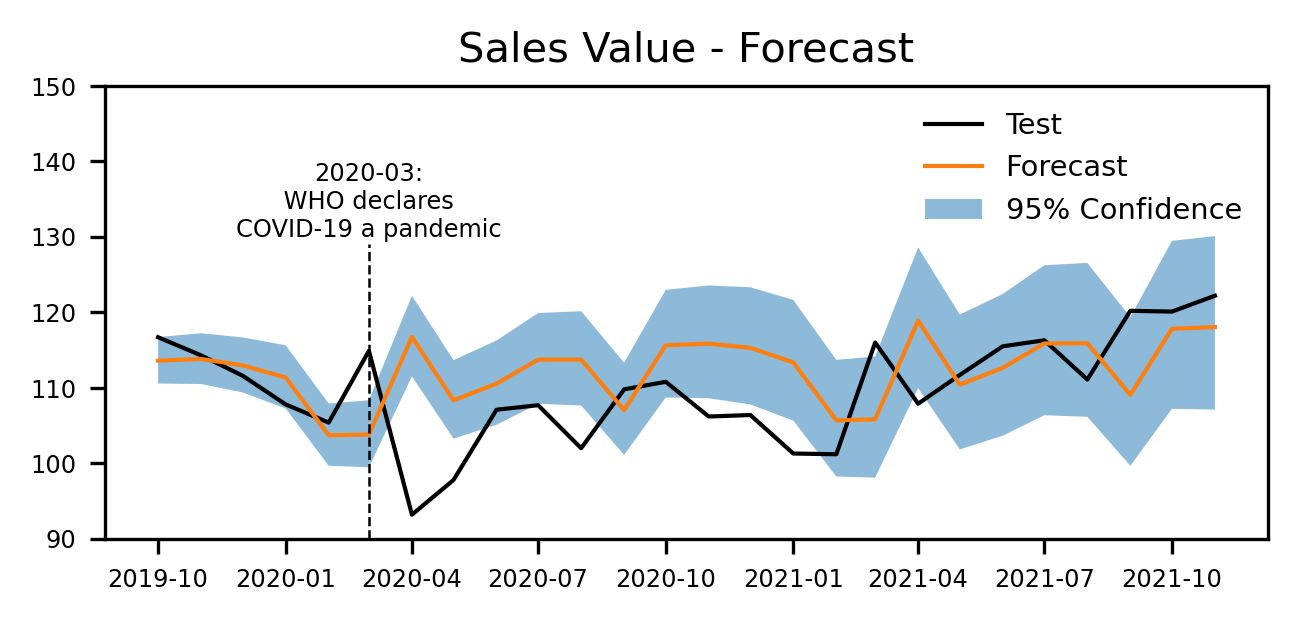

In [21]:
fig, ax = pyplot.subplots(figsize=(5,2))

lineplot(data=test.value, linewidth=1, color='black', label='Test')
lineplot(data=test.forecast, linewidth=1, color='tab:orange', label='Forecast')
ax.fill_between(x=test.index, y1=test.lower, y2=test.upper, 
                alpha=.5, label='95% Confidence')

ax.axvline(x=to_datetime('2020-03'), linestyle='dashed', linewidth=.6, color='black', ymax=.65)
ax.text(s='2020-03:\n WHO declares \nCOVID-19 a pandemic', x=to_datetime('2020-03'), y=130, 
        fontsize='xx-small', horizontalalignment='center')

ax.set(ylim=(90, 150))
ax.set_title('Sales Value - Forecast')
ax.legend(loc='upper right', frameon=False)
ax.set_ylabel(None)
ax.set_xlabel(None)

pyplot.show()

In [22]:
print('RMSE:', round(mean_squared_error(test.value, test.forecast, squared=False), 4))        
print('MAE:', round(mean_absolute_error(test.value, test.forecast), 4)) 
print('MAPE:', round(mean_absolute_percentage_error(test.value, test.forecast), 4))

RMSE: 8.2615
MAE: 6.4378
MAPE: 0.0607


A MAPE equal to 0.0607 means that, on average, the forecast is off by 6.07%